In [2]:
import spacy
import spacy.cli
from spacy import displacy
from nltk.stem import WordNetLemmatizer
from graph.higher_dim_graph import Graph
from graph.graph import visualize_graph
from graph.edge import Edge
from graph.vertex import Vertex

In [3]:
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.5 MB/s eta 0:00:0000:0100:04
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [118]:
nlp = spacy.load("en_core_web_lg")
lemmatizer = WordNetLemmatizer()

## Обработка глагольных рёбер

In [152]:
def get_syntactic_relations(doc):
    """
    Извлекает синтаксические связи (именные группы, включая прилагательные и артикли) из текста.
    Обрабатывает сочетания глагола с предлогом как единое ребро.
    Обрабатывает сочинение (conj), создавая дополнительные связи.
    """
    chunks = []  # Список для хранения именных групп
    relations = []  # Список для хранения связей (субъект, глагол, объект)
    subjects = {}  # Словарь для хранения подлежащих
    conjunctions = {}  # Словарь для хранения связей conj (сочинение)
    chunk_to_text = {}  # Связываем root токены с текстом именных групп

    # Добавляем именные группы (NOUN CHUNKS) и нормализуем их
    for chunk in doc.noun_chunks:
        normalized_chunk = ' '.join([lemmatizer.lemmatize(token.text.lower(), pos='n') for token in chunk])
        chunks.append((chunk.start_char, chunk.end_char, chunk, normalized_chunk, chunk.root.head, chunk.root.dep_))
        chunk_to_text[chunk.root] = normalized_chunk  # Связываем root токен с нормализованным текстом

    # Обрабатываем сочинение (conj)
    for token in doc:
        if token.dep_ == "conj" and token.head in chunk_to_text:
            head_text = chunk_to_text[token.head]
            conj_text = chunk_to_text.get(token, None)  # Используем уже обработанный chunk

            if head_text and conj_text:
                conjunctions.setdefault(head_text, []).append(conj_text)

    # Добавляем подлежащие
    for chunk in chunks:
        if chunk[5] == 'nsubj':
            subject_text = chunk_to_text.get(chunk[2].root, chunk[3])  # Используем нормализованный текст
            subjects.setdefault(chunk[4], []).append(subject_text)

            # Добавляем conj-подлежащие
            if subject_text in conjunctions:
                subjects[chunk[4]].extend(conjunctions[subject_text])

    # Добавляем связи для глаголов и предлогов
    for i, chunk in enumerate(chunks):
        # Связи с глаголами
        if chunk[4].pos_ == 'VERB' and chunk[5] != 'nsubj':
            subject_list = subjects.get(chunk[4], [])
            object_text = chunk_to_text.get(chunk[2].root, chunk[3])  # Используем нормализованный текст

            for subject in subject_list:
                relations.append((subject, chunk[4].text, object_text))

                # Добавляем conj-объекты
                if object_text in conjunctions:
                    for conj in conjunctions[object_text]:
                        relations.append((subject, chunk[4].text, conj))

        # Обрабатываем сочетания глаголов и предлогов как единое ребро
        if chunk[4].pos_ == 'VERB' and i + 1 < len(chunks):
            next_chunk = chunks[i + 1]
            if next_chunk[4].pos_ == 'ADP':  # Если следующий элемент - предлог
                subject_list = subjects.get(chunk[4], [])
                relation_text = f"{chunk[4].text} {next_chunk[4].text}"
                object_text = chunk_to_text.get(next_chunk[2].root, next_chunk[3])

                for subject in subject_list:
                    relations.append((subject, relation_text, object_text))

                    # Добавляем conj-объекты
                    if object_text in conjunctions:
                        for conj in conjunctions[object_text]:
                            relations.append((subject, relation_text, conj))

    return relations

## Обработка предложных рёбер

In [153]:
def find_nearest_vertex(token, chunk_to_vertex):
    """
    Ищет ближайшую вершину для токена, поднимаясь вверх по дереву зависимостей.
    """
    visited = set()
    while token and token not in chunk_to_vertex:
        if token in visited or token.head == token:
            return None  # Защита от бесконечного цикла
        visited.add(token)
        token = token.head  # Поднимаемся выше в дереве
    return chunk_to_vertex.get(token)

In [154]:
def process_token(token, graph, chunk_to_vertex):
    """
    Обрабатывает токен, добавляя рёбра между существующими вершинами (именными группами).
    """
    for child in token.children:
        head_vertex = find_nearest_vertex(token, chunk_to_vertex)
        child_vertex = find_nearest_vertex(child, chunk_to_vertex)
        
        print(f"Checking edge: {token.text} -> {child.text}")
        print(f"Head vertex: {head_vertex}, Child vertex: {child_vertex}")
        
        if head_vertex and child_vertex and token.pos_ == "ADP":  # Обрабатываем только предлоги
            edge_tuple = (head_vertex.concept, child_vertex.concept, token.text)
            
            # Проверяем, есть ли уже такое ребро
            if edge_tuple not in {(e.agent_1, e.agent_2, e.meaning) for e in graph.edges}:
                print(f"Adding edge: {head_vertex.concept} --[{token.text}]--> {child_vertex.concept}")
                graph.add_edge(head_vertex.concept, child_vertex.concept, token.text, 1, 0)
        
        process_token(child, graph, chunk_to_vertex)

## Обработка

In [145]:
def find_nearest_vertex(token, chunk_to_vertex):
    """
    Ищет ближайшую вершину для токена, поднимаясь вверх по дереву зависимостей.
    """
    visited = set()
    while token and token not in chunk_to_vertex:
        if token in visited or token.head == token:
            return None  # Защита от бесконечного цикла
        visited.add(token)
        token = token.head  # Поднимаемся выше в дереве
    return chunk_to_vertex.get(token)

def process_token(token, graph, chunk_to_vertex, conjunctions):
    """
    Обрабатывает токен, добавляя рёбра между существующими вершинами (именными группами).
    """
    for child in token.children:
        head_vertex = find_nearest_vertex(token, chunk_to_vertex)
        child_vertex = find_nearest_vertex(child, chunk_to_vertex)
        
        print(f"Checking edge: {token.text} -> {child.text}")
        print(f"Head vertex: {head_vertex}, Child vertex: {child_vertex}")
        
        if head_vertex and child_vertex and token.pos_ == "ADP":  # Обрабатываем только предлоги
            edge_tuples = [(head_vertex.concept, child_vertex.concept, token.text)]

            # Добавляем связи для сочинённых существительных
            if head_vertex.concept in conjunctions:
                edge_tuples.extend([(conj, child_vertex.concept, token.text) for conj in conjunctions[head_vertex.concept]])
            
            if child_vertex.concept in conjunctions:
                edge_tuples.extend([(head_vertex.concept, conj, token.text) for conj in conjunctions[child_vertex.concept]])

            # Проверяем наличие рёбер и добавляем только новые
            existing_edges = {(e.agent_1, e.agent_2, e.meaning) for e in graph.edges}
            for edge_tuple in edge_tuples:
                if edge_tuple not in existing_edges:
                    print(f"Adding edge: {edge_tuple[0]} --[{edge_tuple[2]}]--> {edge_tuple[1]}")
                    graph.add_edge(edge_tuple[0], edge_tuple[1], edge_tuple[2], 1, 0)
        
        process_token(child, graph, chunk_to_vertex, conjunctions)


Processing token: on (ADP)
Checking edge: on -> mat
Head vertex: Vertex(concept='the cat', words=['the cat']), Child vertex: Vertex(concept='the mat', words=['the mat'])
Checking edge: mat -> the
Head vertex: Vertex(concept='the mat', words=['the mat']), Child vertex: Vertex(concept='the mat', words=['the mat'])


In [149]:
# Создаём словарь для хранения связей conj
chunk_to_vertex = {}
conjunctions = {}  # {главная вершина: [сочинённые вершины]}

# Добавляем вершины только для именных групп (исключаем глаголы и наречия)
for chunk in doc.noun_chunks:
    vertex = Vertex(chunk.text, [chunk.text])
    
    # Проверяем, существует ли вершина с таким концептом
    if vertex.concept not in graph1.vertices:
        graph1.add_vertex(vertex.concept, vertex.words_of_concept)
    
    # Привязываем root токен к вершине
    chunk_to_vertex[chunk.root] = vertex

# Собираем информацию о сочинении (conj)
for token in doc:
    if token.dep_ == "conj" and token.head in chunk_to_vertex:
        head_text = chunk_to_vertex[token.head].concept
        conj_text = chunk_to_vertex.get(token, None)

        if head_text and conj_text:
            conjunctions.setdefault(head_text, []).append(conj_text.concept)

# Добавляем рёбра между существующими вершинами
for token in doc:
    if token.pos_ == "ADP":  # Обрабатываем только предлоги
        print(f"Processing token: {token.text} ({token.pos_})")
        process_token(token, graph1, chunk_to_vertex, conjunctions)

Processing token: on (ADP)
Checking edge: on -> mat
Head vertex: Vertex(concept='the cat', words=['the cat']), Child vertex: Vertex(concept='the mat', words=['the mat'])
Checking edge: mat -> the
Head vertex: Vertex(concept='the mat', words=['the mat']), Child vertex: Vertex(concept='the mat', words=['the mat'])


Создаём граф

In [162]:
# text = """How are living organisms different from inanimate matter? There are obvious answers in terms
# of the chemical composition and structure, but when it comes to the central processes in the evolution
# of life, the distinction is far less obvious. In the tradition of Darwin-Wallace, it is tempting to
# posit that life is defined by evolution through the survival of the fittest. However, the
# uniqueness of this process to life could be questioned because the entire history of the universe
# consists of changes where the most stable structures survive. The process of
# replication itself is not truly unique to biology either: crystals do replicate. On the macroscopic
# scales of space and time, however, life clearly is a distinct phenomenon. To objectively define
# the features that distinguish life from other phenomena that occur mostly in the universe, it seems
# important to examine the key processes of biological evolution within the framework of
# theoretical physics."""
text = 'The dog and the cat eat meat and fish.'
# text = 'The dog and the cat on the mat are sitting'
text = text.replace('\n', ' ')
    
doc = nlp(text)
pairs = get_syntactic_relations(doc)
graph1 = Graph()

Добавляем глагольные рёбра

In [163]:
# Добавляем вершины и рёбра
for pair in pairs:
    try:
        graph1.add_vertex(pair[0])
    except:
        pass
    try:
        graph1.add_vertex(pair[2])
    except:
        pass
    graph1.add_edge(pair[0], pair[2], pair[1], 0, 0)

Добавляем предложные рёбра

In [164]:
chunk_to_vertex = {}

# Добавляем вершины только для именных групп (исключаем глаголы и наречия)
for chunk in doc.noun_chunks:
    vertex = Vertex(chunk.text, [chunk.text])
    
    # Проверяем, существует ли вершина с таким концептом
    if vertex.concept not in graph1.vertices:
        graph1.add_vertex(vertex.concept, vertex.words_of_concept)
    
    # Привязываем root токен к вершине
    chunk_to_vertex[chunk.root] = vertex

# Добавляем рёбра между существующими вершинами
for token in doc:
    if token.pos_ == "ADP":  # Обрабатываем только предлоги
        print(f"Processing token: {token.text} ({token.pos_})")
        process_token(token, graph1, chunk_to_vertex)

Чистим граф от пустых вершин

In [165]:
graph_res = Graph()
print(graph1.vertices)
for concept in graph1.vertices.keys():
    if graph1.get_vertex_edges(concept):
        graph_res.add_vertex(concept)
for edge in graph1.edges:
    graph_res.add_edge(edge.agent_1, edge.agent_2, edge.meaning, 0, 0)

{'the dog': Vertex(concept='the dog', words=['the dog']), 'meat': Vertex(concept='meat', words=['meat']), 'fish': Vertex(concept='fish', words=['fish']), 'the cat': Vertex(concept='the cat', words=['the cat']), 'The dog': Vertex(concept='The dog', words=['The dog'])}


In [159]:
# Выводим граф
print("Graph structure:")
print(graph_res)
print("\nDetailed representation:")
print(repr(graph_res))

print("\nEdges:")
for concept in graph_res.vertices.keys():
    print(f"Concept: {concept}")
    print(graph_res.get_vertex_edges(concept))

print("\nVertices:")
for concept in graph_res.vertices.keys():
    print(graph_res.vertices[concept])

Graph structure:
Graph(vertices=29, edges=20)

Detailed representation:
Graph(
	vertices=[Vertex(concept='it', words=['it']), Vertex(concept='the central process', words=['the central process']), Vertex(concept='the entire history', words=['the entire history']), Vertex(concept='the universe', words=['the universe']), Vertex(concept='crystal', words=['crystal']), Vertex(concept='the macroscopic scale', words=['the macroscopic scale']), Vertex(concept='that', words=['that']), Vertex(concept='life', words=['life']), Vertex(concept='other phenomenon', words=['other phenomenon']), Vertex(concept='living organisms', words=['living organisms']), Vertex(concept='inanimate matter', words=['inanimate matter']), Vertex(concept='terms', words=['terms']), Vertex(concept='the chemical composition', words=['the chemical composition']), Vertex(concept='the evolution', words=['the evolution']), Vertex(concept='the tradition', words=['the tradition']), Vertex(concept='Darwin-Wallace', words=['Darwin-Wa

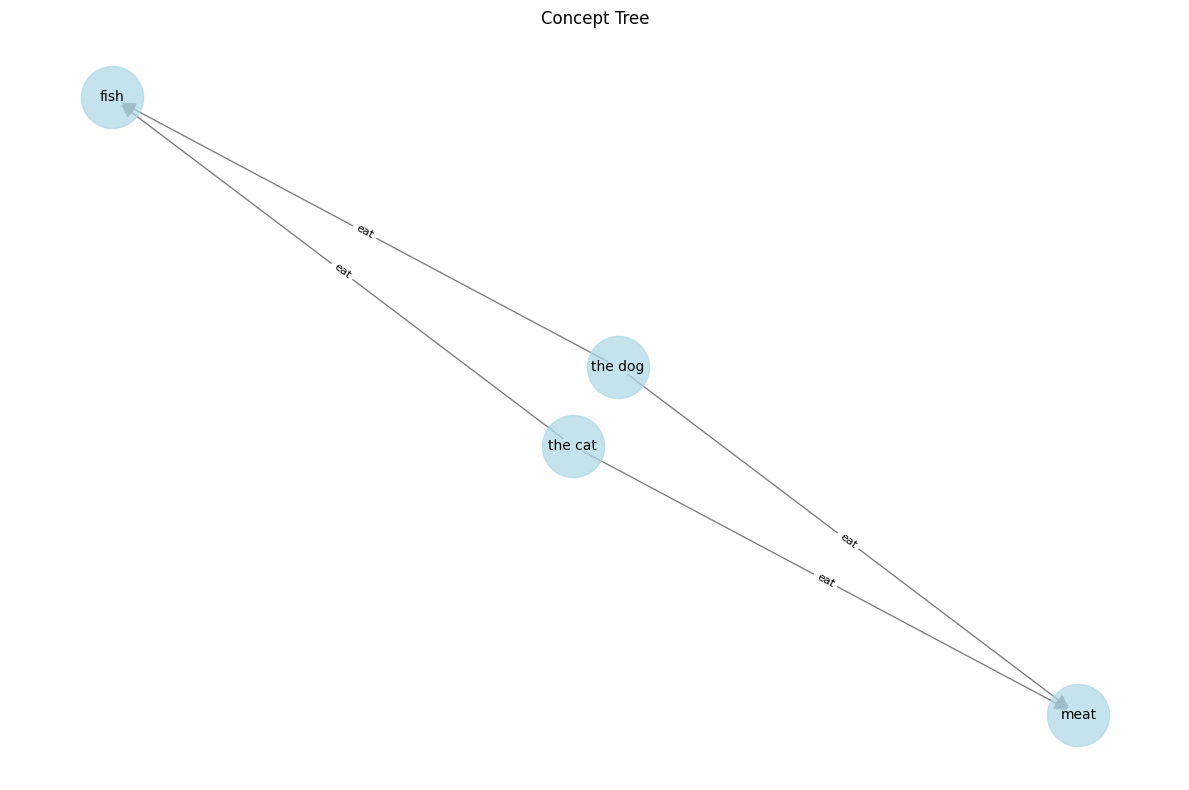

In [166]:
visualize_graph(graph_res)

In [33]:
displacy.render(doc, style='dep')

To Do:
- плохо справляется с эллипсисом (survival of the fittest)
- различать и или два разных симплекса
- спросить у димы симплекс
- связать сочинение отдельной категорией
